In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

SHOW_GIFS = False

In [2]:
import numpy as np
import matplotlib.pylab as plt
import functions as fn
import execution as pso
import strategies
import plotting as plot

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


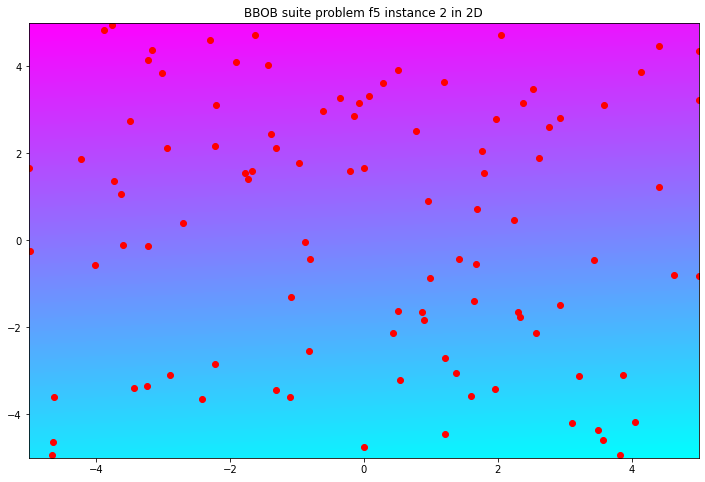

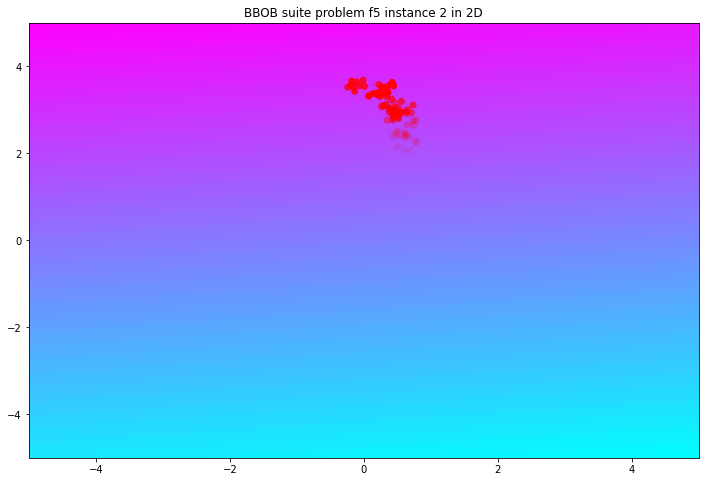

In [3]:
with fn.get_functions(dimension=[2], function_indices=[5]) as suite:
    for function in suite:  # type: fn.cocoex.Problem
        populations, values = pso.execute_multiple(
            function,
            strategies.RandomWalkObject.execute,
            initialization=strategies.RandomWalkObject.initialize,
            repeats=10,
            show_progress=True
        )

        plot.plot_population(function, populations[2, -1])

        plot.plot_movement_of_individual(function, populations[2, :,5,:])

        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations[2], figsize=(12,8))
            display.Image(data=gif, format='png')

<Figure size 864x576 with 0 Axes>

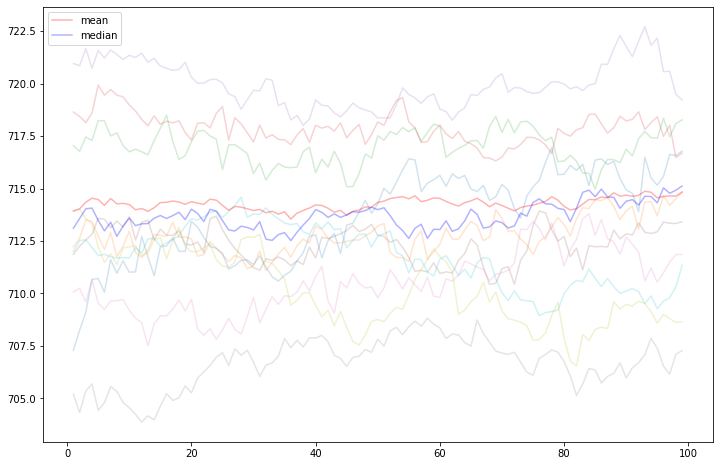

In [4]:
plt.figure(figsize=(12,8))

for val in values:
    plot.plot_graph(val, plot.plotfn_median(), alpha=0.2)
plot.plot_aggregated(values+1, plot.plotfn_median(), plot.aggfn_mean(), label="mean", c='r', alpha=0.3)
plot.plot_aggregated(values+1, plot.plotfn_median(), plot.aggfn_median(), label="median", c='b', alpha=0.3)

plt.legend()
plt.show()